In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
user = pd.read_csv('pca_SOM.csv')
user2 = pd.read_csv('X_SOM.csv')

In [5]:
pca_xy = pd.read_csv('pca_XY.csv')

In [6]:
user['y'] = pca_xy['y']

In [7]:
g1 = user[user.cluster=='[0 0]']
g1 = g1.drop(['Unnamed: 0','cluster'],axis=1)
g2 = user[user.cluster=='[0 1]']
g2 = g2.drop(['Unnamed: 0','cluster'],axis=1)
g3 = user[user.cluster=='[0 2]']
g3 = g3.drop(['Unnamed: 0','cluster'],axis=1)
g4 = user[user.cluster=='[1 0]']
g4 = g4.drop(['Unnamed: 0','cluster'],axis=1)
g5 = user[user.cluster=='[1 1]']
g5 = g5.drop(['Unnamed: 0','cluster'],axis=1)
g6 = user[user.cluster=='[1 2]']
g6 = g6.drop(['Unnamed: 0','cluster'],axis=1)

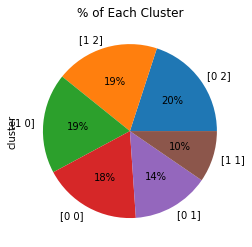

In [8]:
#plt.figure(figsize=(8,8))
user.cluster.value_counts().plot(kind='pie',title='% of Each Cluster', autopct='%1.0f%%')

In [9]:
bank = pd.read_csv('bank-full.csv')

In [10]:
bank.shape

(45211, 17)

In [11]:
bank['cluster'] = user2['cluster']

In [12]:
bank.groupby('cluster').mean().round(1)

,age,balance,day,duration,campaign,pdays,previous
cluster,,,,,,,
[0 0],36.7,1358.9,16.0,243.2,2.6,12.8,0.3
[0 1],34.5,1117.8,15.1,243.1,2.2,56.1,0.9
[0 2],34.5,902.2,15.2,255.2,2.3,99.1,0.9
[1 0],52.7,1315.5,17.1,233.6,2.8,13.5,0.3
[1 1],45.9,964.2,16.7,214.9,2.6,11.3,0.2
[1 2],42.1,731.7,14.6,236.3,2.4,19.9,0.2


### cluster별 classification

In [13]:
g1.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,y
4,-0.177710,-0.209624,0.114222,-1.221593,0.386855,-1.166395,0.406823,-0.747862,0.214874,0
81,-0.292412,0.299382,-0.043784,-0.880987,0.441120,-1.635924,0.266442,-0.594810,0.054039,0
128,-0.297891,0.303268,-0.273403,-0.900040,0.401537,-1.535050,0.296852,-0.637470,0.063114,0
158,-0.389285,1.195420,0.198047,-1.578589,0.997530,0.414187,0.251732,-0.918468,0.923488,1
217,-0.319317,0.228832,-0.324262,-1.012653,0.182281,-0.909885,0.342597,-0.448808,0.522745,0


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [15]:
from lightgbm import LGBMClassifier

In [16]:
def traintestsplit(df):
    X, y = df.iloc[:,:-1], df.iloc[:,-1]
    X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    return X_train,X_test,y_train,y_test

In [17]:
def hypertuning_rscv(est, p_distr, nbr_iter,X,y):
    rdmsearch = RandomizedSearchCV(est, param_distributions=p_distr, n_iter=nbr_iter, cv=5, scoring='accuracy', random_state=42)
    rdmsearch.fit(X,y)
    ht_params = rdmsearch.best_params_
    ht_score = rdmsearch.best_score_
    return ht_params, ht_score

lgbm_params ={'max_depth': np.arange(3, 30),
             'num_leaves': np.arange(10, 50), 
             'learning_rate': [ 0.01, 0.03, 0.05],
             'min_child_samples': randint(2, 30),
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': np.linspace(0.6, 0.9, 30, endpoint=True), 
             'colsample_bytree': np.linspace(0.1, 0.8, 100, endpoint=True),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
             'n_estimators': np.arange(100, 200)}

In [18]:
def train_test_acc(df):
    X_train,X_test,y_train,y_test = traintestsplit(df)
    
    clf = LGBMClassifier()
    best_params = hypertuning_rscv(clf, lgbm_params, 30, X_train, y_train)    
    lgb_model = LGBMClassifier(**best_params[0])
    lgb_model.fit(X_train,y_train)
    train_pred = lgb_model.predict(X_train)
    test_pred = lgb_model.predict(X_test)
    train_acc = accuracy_score(y_train,train_pred).round(3)
    test_acc = accuracy_score(y_test,test_pred).round(3)
    return train_acc, test_acc

In [19]:
accuracylist = []
for i in [g1,g2,g3,g4,g5,g6]:
    accuracylist.append(train_test_acc(i))
    print(train_test_acc(i))

(0.898, 0.835)
(0.89, 0.86)
(0.955, 0.925)
(0.891, 0.876)
(0.947, 0.939)
(0.968, 0.959)


### SHAP

In [20]:
user2['y'] = bank['y']

In [21]:
g1_shap = user2[user2.cluster=='[0 0]'].drop(['Unnamed: 0','cluster'],axis=1)
g2_shap = user2[user2.cluster=='[0 1]'].drop(['Unnamed: 0','cluster'],axis=1)
g3_shap = user2[user2.cluster=='[0 2]'].drop(['Unnamed: 0','cluster'],axis=1)
g4_shap = user2[user2.cluster=='[1 0]'].drop(['Unnamed: 0','cluster'],axis=1)
g5_shap = user2[user2.cluster=='[1 1]'].drop(['Unnamed: 0','cluster'],axis=1)
g6_shap = user2[user2.cluster=='[1 2]'].drop(['Unnamed: 0','cluster'],axis=1)

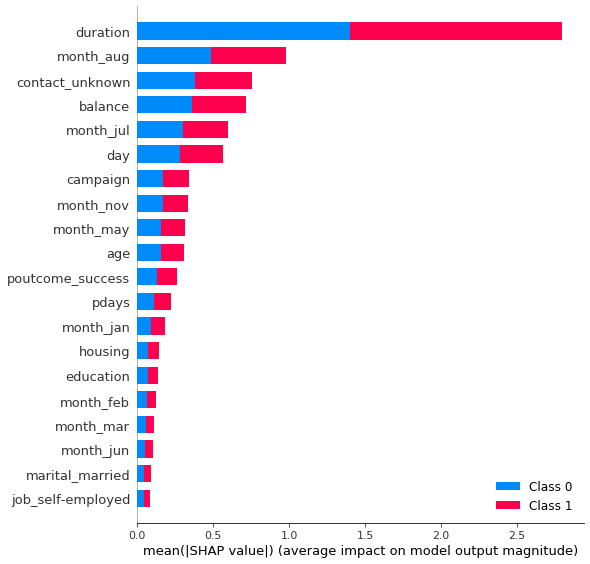

In [22]:
import shap
import skimage

lgb_model = LGBMClassifier()
lgb_model.fit(traintestsplit(g1_shap)[0],traintestsplit(g1_shap)[2])
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(traintestsplit(g1_shap)[1])
shap.summary_plot(shap_values, traintestsplit(g1_shap)[1], plot_type = 'bar')

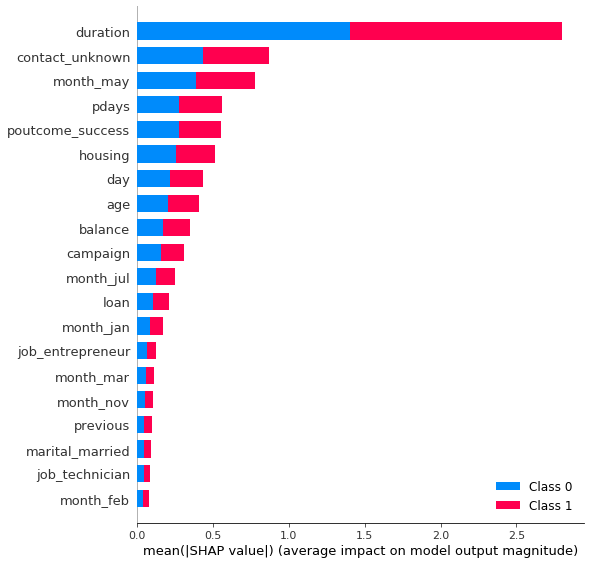

In [23]:
lgb_model = LGBMClassifier()
lgb_model.fit(traintestsplit(g2_shap)[0],traintestsplit(g2_shap)[2])
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(traintestsplit(g2_shap)[1])
shap.summary_plot(shap_values, traintestsplit(g2_shap)[1], plot_type = 'bar')

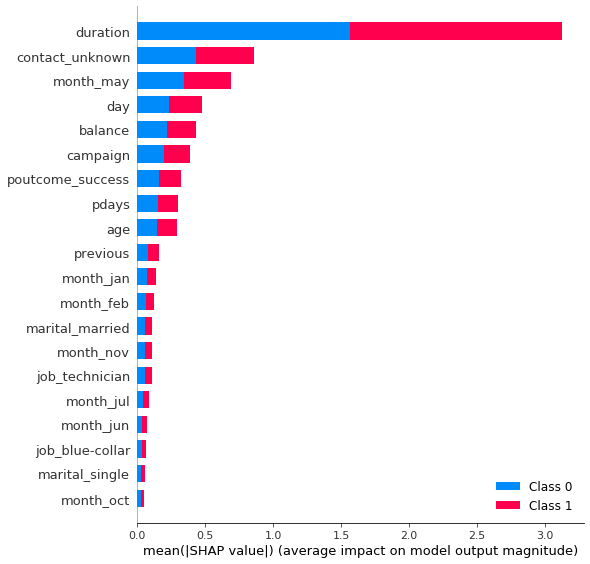

In [24]:
lgb_model = LGBMClassifier()
lgb_model.fit(traintestsplit(g3_shap)[0],traintestsplit(g3_shap)[2])
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(traintestsplit(g3_shap)[1])
shap.summary_plot(shap_values, traintestsplit(g3_shap)[1], plot_type = 'bar')

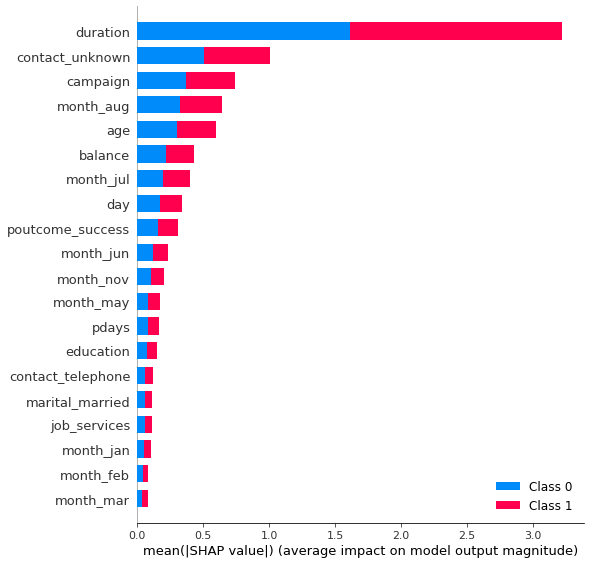

In [25]:
lgb_model = LGBMClassifier()
lgb_model.fit(traintestsplit(g4_shap)[0],traintestsplit(g4_shap)[2])
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(traintestsplit(g4_shap)[1])
shap.summary_plot(shap_values, traintestsplit(g4_shap)[1], plot_type = 'bar')

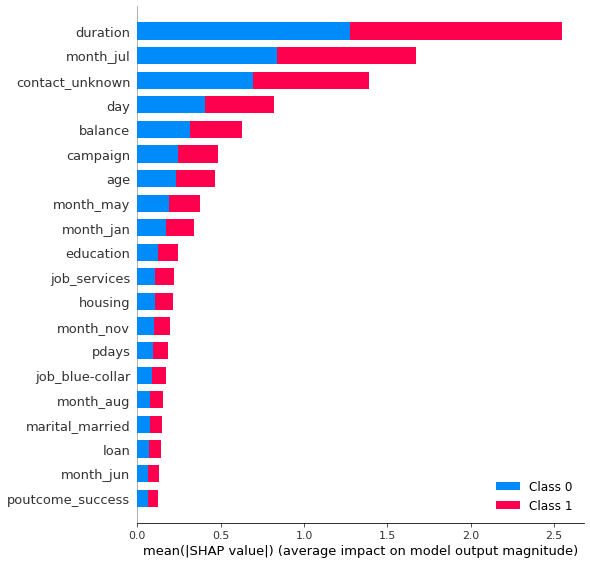

In [26]:
lgb_model = LGBMClassifier()
lgb_model.fit(traintestsplit(g5_shap)[0],traintestsplit(g5_shap)[2])
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(traintestsplit(g5_shap)[1])
shap.summary_plot(shap_values, traintestsplit(g5_shap)[1], plot_type = 'bar')

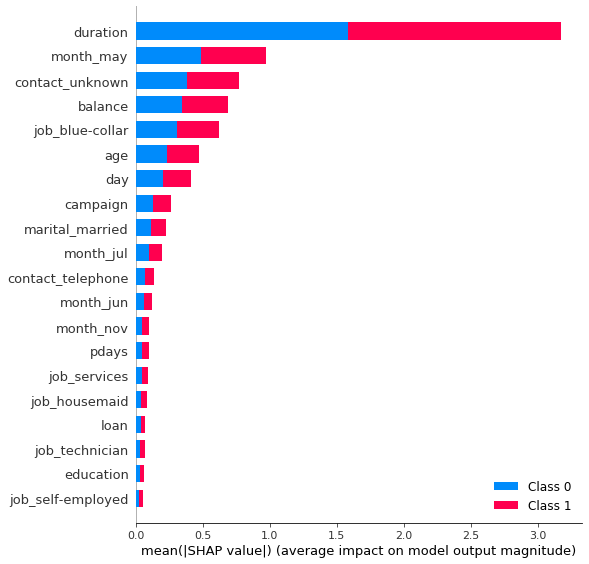

In [27]:
lgb_model = LGBMClassifier()
lgb_model.fit(traintestsplit(g6_shap)[0],traintestsplit(g6_shap)[2])
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(traintestsplit(g6_shap)[1])
shap.summary_plot(shap_values, traintestsplit(g6_shap)[1], plot_type = 'bar')

In [35]:
import pandas as pd
df = pd.DataFrame({'X':[3,4,4,6,2,5],'Y':[6,3,4,6,5,3],'Group':[1,1,1,2,2,2]})
df

,Group,X,Y
0,1,3,6
1,1,4,3
2,1,4,4
3,2,6,6
4,2,2,5
5,2,5,3
